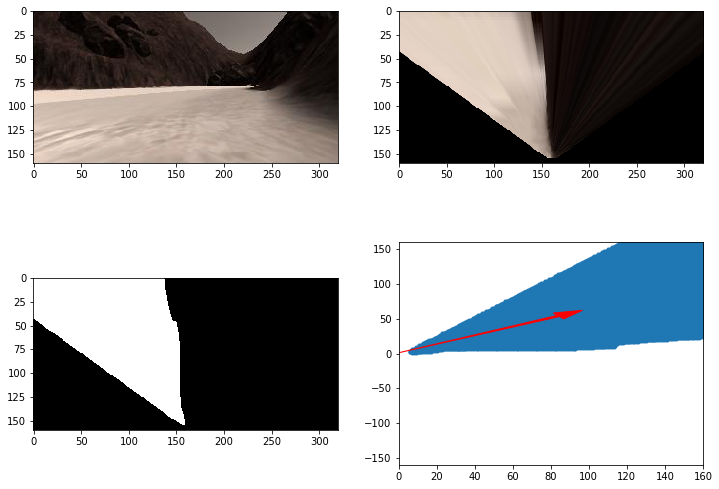

In [12]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob
#%matplotlib notebook
#%matplotlib qt
%matplotlib inline


#GRAB A RANDOM IMAGE
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

#WARPED PERSPECIVE TRANSFORM
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    masked = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    return warped, masked

dst_size = 5 
bottom_offset = 6
source = np.float32([[15, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

#WARPED NAIGABLE AND OBSTACLE
warped, masked = perspect_transform(image, source, destination)
#WARPED GOLD ROCKS/SAMPLES
warped_rock,_ = perspect_transform(image_cv2, source, destination)

#scipy.misc.imsave('../output/warped_example.jpg', warped)

#GROUND
def navigable_thresh(img):
    image_otsu = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(image_otsu,(5,5),0)
    ret2,threshed_ground = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return threshed_ground

navi_world = navigable_thresh(warped)

#OBSTACLES
#def obstacle_thresh(img):
#    blur = cv2.GaussianBlur(img,(5,5),0)
#    ret2,threshed_obstacle = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#    return threshed_obstacle

#obstacle_world = obstacle_thresh(warped)
obst_world = np.absolute(np.float32(navi_world) - 1) * masked

#GOLD ROCKS
#warped_rock = perspect_transform(image_cv2, source, destination)
def rock_thresh(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([4,100,100])
    upper_yellow = np.array([33,255,255])
    threshed_sample = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return threshed_sample

rock_world = rock_thresh(warped_rock)

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)



# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world



# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(navi_world)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(navi_world, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
